In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression,HuberRegressor,LinearRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import RidgeClassifier,ridge_regression,LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve


In [2]:
# Read datas
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Create X and Y datas
X = df_train.drop(columns=['id','smoking'])
y = df_train['smoking']
df_test = df_test.drop(columns='id')

# Split data into train and test for demonstration purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

ROC AUC Score: 0.88


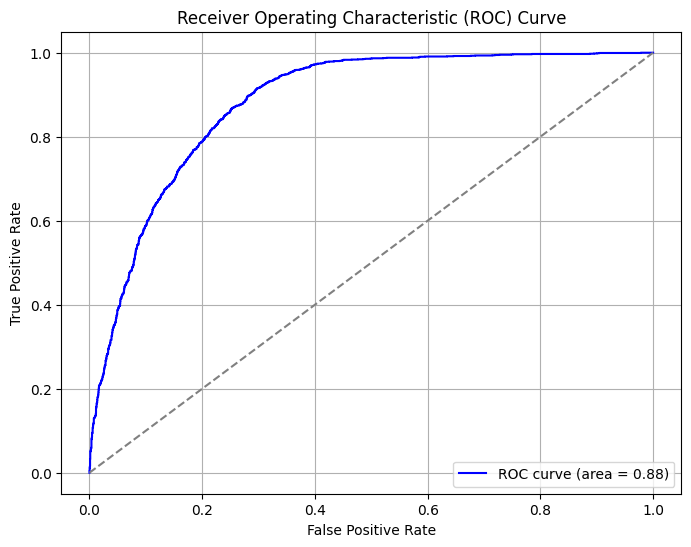

In [3]:
# Step 1: Apply polynomial feature expansion without scaling
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 2: Train the RandomForestClassifier
model = RandomForestClassifier( criterion= 'entropy',
        min_samples_split=6,
        min_samples_leaf=10,
        max_depth=19,
        max_features='sqrt',
        n_estimators=493,
        bootstrap=True,
        random_state=42,
        n_jobs=-1)
model.fit(X_train_poly, y_train)

# Step 3: Get predicted probabilities for ROC AUC
y_pred_proba = model.predict_proba(X_test_poly)[:, 1]  # Probability for the positive class (smoking=1)

# Step 4: Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [4]:
# Apply polynomial feature transformation on the new test data
X_test_poly_new = poly.transform(df_test)

# Get predicted probabilities for the positive class (smoking=1)
y_pred_proba_new = model.predict_proba(X_test_poly_new)[:, 1]

# Submit result
submission['smoking'] = y_pred_proba_new
submission.to_csv('my_submission.csv',index=False)